###### Written by: Sam Johnson and Mohammad Shafkat Islam
###### Date: November 7, 2018
###### Purpose: Segmentation of Optic Disc from Color Fundus Photographs using U-Net
###### Course Project: Deep Learning

In [4]:
# Import matplotlib, numpy etc.
import os
import sys
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.image import imread
import matplotlib.image as mpimg
import sklearn as skplt
from scipy import misc
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc#, jaccard_similarity_SS
from sklearn import metrics
import imageio
#from scipy.misc import imread, imsave, imresize
from PIL import Image
from numpy import mean
from scipy import interp, stats
import datetime
from scipy import ndimage
a = datetime.datetime.now()
#from scipy.misc import imsave, imresize
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels

In [5]:
# Define data paths
root_data_path = "/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/Data/REFUGE-Training400/Training400"
root_mask_path = "/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/Data/Annotation-Training400/Annotation-Training400/Disc_Cup_Masks"
# get a list of all fundus photograph files to be used in the model
fundus_files = glob(root_data_path + "/**/*.jpg")
mask_files = glob(root_mask_path + "/**/*.bmp")
print(len(fundus_files))
print(len(mask_files))

400
400


/local/vol00/scratch/Shafkat/anaconda2/envs/tensorflow_gpuenv/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/local/vol00/scratch/Shafkat/anaconda2/envs/tensorflow_gpuenv/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Here goes Image 1


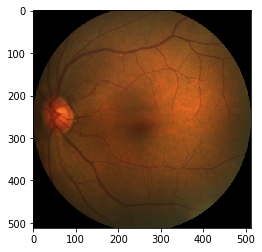

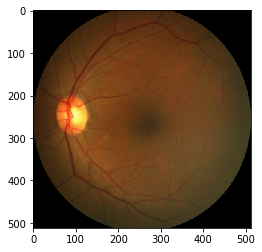

(250, 512, 512, 3) (150, 512, 512, 3)


In [6]:
# Arrange the images:
images = []

# for each file in the list, read in the image, and then save to the array
for photo in fundus_files:
    #print photo
    image = misc.imread(photo).astype(np.float32)/255.0
    ds_image = misc.imresize(image, ((512,512,3)))
    # pass in only the blue channel as it contains the most information 
    images.append(ds_image)


# print img_1.shape
# print img_2.shape
print ("Here goes Image 1")
# print img_1.dtype, img_1.shape, img_1
plt.imshow(images[9])
plt.show()
plt.imshow(images[30])
plt.show()
x_train = np.array(images[:250])
x_validation = np.array(images[250:])
print x_train.shape, x_validation.shape

/local/vol00/scratch/Shafkat/anaconda2/envs/tensorflow_gpuenv/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/local/vol00/scratch/Shafkat/anaconda2/envs/tensorflow_gpuenv/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Here goes Image 1


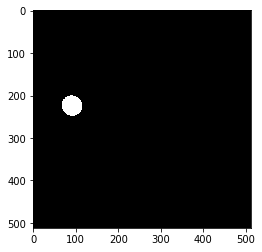

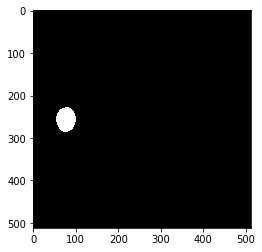

(250, 512, 512) (150, 512, 512)
(250, 512, 512, 1) (150, 512, 512, 1)


In [7]:
## Arrange the labels for purposes of training:
masks = []
# for each file in the list, read in the image, and then save to the array
for photo in mask_files:
    image = misc.imread(photo).astype(np.float32)/255.0
    #print image.shape
    ds_image = misc.imresize(image, ((512,512,1)))
    ds_bi_image = np.invert(ds_image>0)
    #ds_in_bi_image = 
    #print ds_bi_image.shape
    #plt.show(ds_bi_image)
    #print ds_image.shape
    # pass in only the blue channel as it contains the most information 
    masks.append(ds_bi_image)
    #print ds_image.shape
print ("Here goes Image 1")
# print img_1.dtype, img_1.shape, img_1
plt.imshow(masks[9], cmap='Greys_r')
plt.show()
plt.imshow(masks[30], cmap='Greys_r')
plt.show()
#print masks.shape
y_train = np.array(masks[:250])
y_validation  = np.array(masks[250:])
print y_train.shape, y_validation.shape

## So until now the network predicts the labels in one extra channel so I had to expand the channel of the labels
y_train = np.expand_dims(y_train, axis=3)
y_validation = np.expand_dims(y_validation, axis=3)
print y_train.shape, y_validation.shape


### Here is our Fancy U-Net

In [22]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, UpSampling2D, concatenate, merge

def unet(pretrained_weights = None,input_size = (512,512,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6],axis=3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'softmax')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    #model = tf.keras.models.Sequential()
    #model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
unet()

In [23]:
# Save the Checkpoint Directory
checkpoint_path = "/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True, period=1)
# Check for Latest Checkpoints:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

u'/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/checkpoints/cp-0001.ckpt'

In [24]:



## Start Training on the Network:
model = unet()
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
#model.fit(x_train, y_train, epochs=10, batch_size=20, validation_data = (x_validation,y_validation), callbacks = [cp_callback]) 
#score = model.evaluate(x_train, new_y_train, batch_size=12)

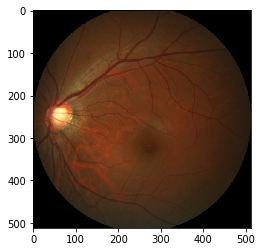

In [17]:
plt.imshow(x_train[0])
plt.show()

(1, 512, 512, 3)
(512, 512, 3)


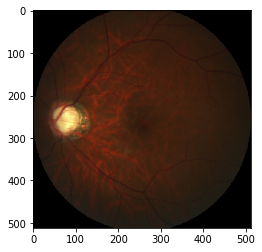

1/1 [==============================] - 6s 6s/step


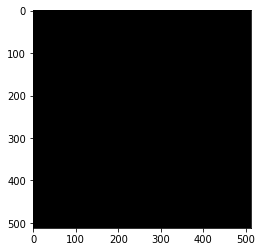

(1, 512, 512, 3)
(512, 512, 3)


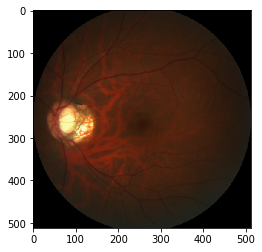

1/1 [==============================] - 5s 5s/step


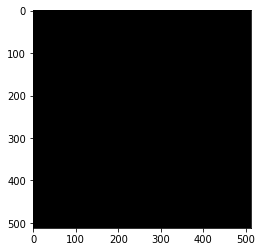

(1, 512, 512, 3)
(512, 512, 3)


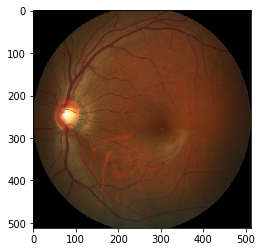

1/1 [==============================] - 5s 5s/step


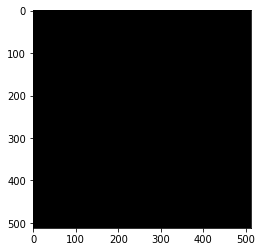

(1, 512, 512, 3)
(512, 512, 3)


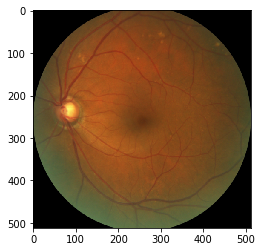

1/1 [==============================] - 3s 3s/step


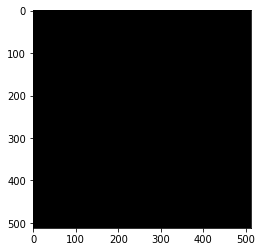

(1, 512, 512, 3)
(512, 512, 3)


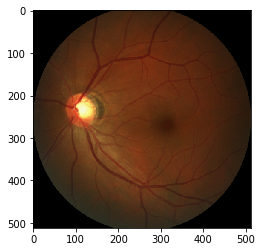

1/1 [==============================] - 4s 4s/step


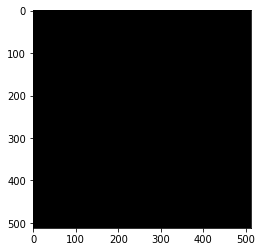

(1, 512, 512, 3)
(512, 512, 3)


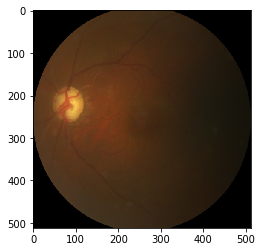

1/1 [==============================] - 4s 4s/step


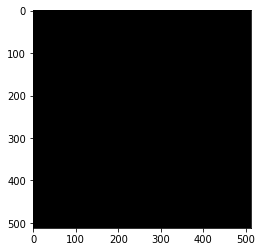

(1, 512, 512, 3)
(512, 512, 3)


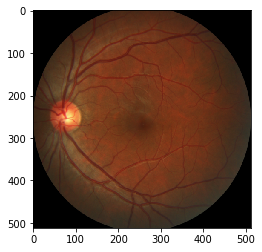

1/1 [==============================] - 5s 5s/step


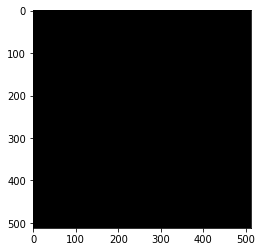

(1, 512, 512, 3)
(512, 512, 3)


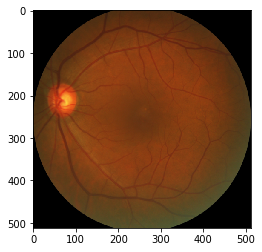

1/1 [==============================] - 5s 5s/step


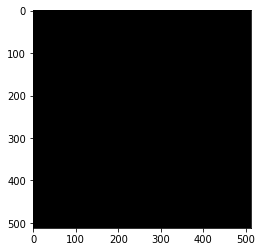

(1, 512, 512, 3)
(512, 512, 3)


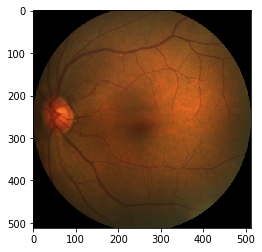

1/1 [==============================] - 6s 6s/step


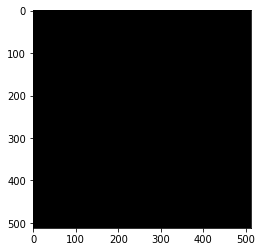

In [26]:
# To test and visualize the output:

model = unet()
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.load_weights(latest)
#loss, acc = model.evaluate(x_validation[0], y_validation[0])
for index in range (1,10):
    current_test_image = np.expand_dims(x_train[index], axis=0)
    print current_test_image.shape
    show_image = np.squeeze(current_test_image, axis=0)
    print show_image.shape
    plt.imshow(show_image)
    plt.show()
    results = model.predict(current_test_image, verbose=1)
    #print results.shape
    new_result = np.squeeze(results, axis=0)
    new_result = np.squeeze(new_result, axis=2)
    #print new_result
    plt.imshow(new_result, cmap='Greys_r')
    plt.show()
#saveResult("/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/results",results)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))

In [15]:
myGene = trainGenerator(2,'/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/Data','Train','Label', data_gen_args,save_to_dir = None)

NameError: name 'trainGenerator' is not defined

In [ ]:
model = unet()
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/membrane/test",results)


## Future Work:

In [12]:
## Data Normalization:
overall_max = 0
overall_min = 0

# scroll through all images to get max and min across all images
for image in images:
    if ndimage.maximum(image) > overall_max:
        overall_max = ndimage.maximum(image)
    if ndimage.minimum(image) < overall_min:
        overall_min = ndimage.minimum(image)

# For each images in the dataset, normalize it using the above found max and mins 
# We will also augment each image by flipping it left/right so we double our datasize
normalized_images = []
flipped_images = []
for image in images:
    # normalize the image
    normalized_image = image - overall_min
    normalized_image = normalized_image / overall_max
    # add to list of normalized images
    normalized_images.append(normalized_image)
    # add augmented normalized image to separate list
    flipped_images.append(np.fliplr(normalized_image))
    
all_images = normalized_images + flipped_images
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(normalized_images[9])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(images[9])
print(ndimage.maximum(images[11]))
print(ndimage.maximum(normalized_images[11]))
print(len(all_images))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 512, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 

In [57]:
# Data Augmentation:

def image_augmentation(image, mask):
    """Returns (maybe) augmented images
    (1) Random flip (left <--> right)
    (2) Random flip (up <--> down)
    (3) Random brightness
    (4) Random hue
    Args:
        image (3-D Tensor): Image tensor of (H, W, C)
        mask (3-D Tensor): Mask image tensor of (H, W, 1)
    Returns:
        image: Maybe augmented image (same shape as input `image`)
        mask: Maybe augmented mask (same shape as input `mask`)
    """
    concat_image = tf.concat([image, mask], axis=-1)

    maybe_flipped = tf.image.random_flip_left_right(concat_image)
    maybe_flipped = tf.image.random_flip_up_down(concat_image)

    image = maybe_flipped[:, :, :-1]
    mask = maybe_flipped[:, :, -1:]

    image = tf.image.random_brightness(image, 0.7)
    image = tf.image.random_hue(image, 0.3)

    return image, mask

In [ ]:
## Toy Network for Practice:

# import tensorflow as tf
# tf.reset_default_graph() # Clear graph before to add things.
# model = tf.keras.models.Sequential()

# #model.add(tf.keras.layers.Input((512,512,3)))
# conv1_1 = model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding = 'same', input_shape=(512,512,3)))
# conv1_2 = model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding = 'same'))(conv1_1)
# pool1 = model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# conv2_1 = model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding = 'same'))
# conv2_2 = model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding = 'same'))
# pool2 = model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# conv3_1 = model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding = 'same'))
# conv3_2 = model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding = 'same'))
# pool3 = model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# conv4_1 = model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding = 'same'))
# conv4_2 = model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding = 'same'))
# pool4 = model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# conv5_1 = model.add(tf.keras.layers.Conv2D(1024, kernel_size=(3,3), activation='relu', padding = 'same'))
# conv5_2 = model.add(tf.keras.layers.Conv2D(1024, kernel_size=(3,3), activation='relu', padding = 'same'))
# pool5 = model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# """
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dense(10, activation='relu'))"""
# #model.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'))
# # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# # model.add(tf.keras.layers.Flatten())
# # model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
# model.summary()


In [ ]:
# ## Toy Network: Practice Training: It works
# x_train_random = np.random.random((100, 100, 100, 3))
# y_train_random = tf.keras.utils.to_categorical(np.random.randint(10, size=(100, 1)), num_classes=10)
# x_test_random = np.random.random((20, 100, 100, 3))
# y_test_random = tf.keras.utils.to_categorical(np.random.randint(10, size=(20, 1)), num_classes=10)
# print x_train_random.shape, y_train_random.shape
# print x_train.shape, y_train.shape

In [5]:
## Toy Network for Practice:
# def build_the_network():
#     input_layer = tf.keras.layers.Input(shape=(530,514,3))

#     conv_1 = tf.keras.layers.Conv2D(16,
#                                     kernel_size=(3,3),
#                                     activation='relu')(input_layer)
#     conv_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_1)

#     conv_2 = tf.keras.layers.Conv2D(16,
#                                     kernel_size=(3,3),
#                                     activation='relu')(conv_1)
#     conv_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_2)

#     conv_3 = tf.keras.layers.Conv2D(16,
#                                     kernel_size=(3,3),
#                                     activation='relu')(conv_2)
#     conv_3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_3)

#     flattened = tf.keras.layers.Flatten()(conv_3)
    
#     fc_1 = tf.keras.layers.Dense(128, activation='relu')(flattened)
    
#     output_layer = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(fc_1)
    
#     return output_layer


In [6]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, UpSampling2D, concatenate, merge

In [10]:
x_train_random = np.random.random((100, 100, 100, 3))
y_train_random = tf.keras.utils.to_categorical(np.random.randint(10, size=(100, 1)), num_classes=10)
x_test_random = np.random.random((20, 100, 100, 3))
y_test_random = tf.keras.utils.to_categorical(np.random.randint(10, size=(20, 1)), num_classes=10)
print x_train_random.shape, y_train_random.shape
print x_train.shape, y_train.shape

(100, 100, 100, 3) (100, 10)
(100, 512, 512, 3) (100, 512, 512)


In [23]:
print y_train.shape
new_y_train = np.expand_dims(y_train, axis=3)
print new.shape

(100, 512, 512)
(100, 512, 1, 512)


In [ ]:
x_train = np.array(images)
y_train = np.array(masks)
model = unet()
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(x_train, new_y_train, epochs=1, batch_size=5)
#score = model.evaluate(x_train, new_y_train, batch_size=12)

In [ ]:
# y_train = np.expand_dims(y_train,3).astype('float')/255.0
#y_train = tf.keras.utils.to_categorical(y_train)
# x_train = tf.keras.utils.to_categorical(x_train)
print(y_train.shape)

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1, batch_size=5)

